In [18]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
import os
import sys

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Hei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# ================= 配置路径 =================
def find_project_root(current_path, marker='results'):
    current_path = os.path.abspath(current_path)
    if os.path.exists(os.path.join(current_path, marker)):
        return current_path
    parent = os.path.dirname(current_path)
    if parent == current_path: raise FileNotFoundError()
    return find_project_root(parent, marker)

try:
    PROJECT_ROOT = find_project_root(os.getcwd())
    print(f"✅ 定位根目录: {PROJECT_ROOT}")
except:
    # 如果自动失败，请手动修改这里！
    PROJECT_ROOT = '/Users/day/Desktop/书架/大三上/LOB-Spread-Regime'
    print(f"⚠️ 使用硬编码路径: {PROJECT_ROOT}")

MODEL_PATH = os.path.join(PROJECT_ROOT, 'results', 'models', 'LightGBM.pkl')

# 数据路径 (使用旧项目的 sample 文件)
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_for_shap.parquet') 

# 缓存路径
CACHE_PATH = os.path.join(PROJECT_ROOT, 'results', 'shap_interaction_cache.npy')

# 特征列表
FEATURE_COLS = [
    'Accum_Vol_Diff', 'VolumeMax', 'VolumeAll', 'Immediacy', 'Depth_Change', 
    'LobImbalance', 'DeepLobImbalance', 'Relative_Spread', 'Micro_Mid_Spread', 
    'PastReturn', 'Lambda', 'Volatility', 'AutoCov'
]

✅ 定位根目录: /Users/day/Desktop/书架/大三上/LOB-Spread-Regime


In [19]:
# 1. 加载模型
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"未找到模型文件: {MODEL_PATH}\n请确认已将旧版 LightGBM.pkl 复制到 results/models/ 目录下。")

print(f"正在加载模型: {MODEL_PATH} ...")
model = joblib.load(MODEL_PATH)

# 2. 加载数据
# 如果没有 parquet，这里提供一个生成随机数据的 fallback (仅供调试代码跑通)
if os.path.exists(DATA_PATH):
    print(f"正在加载数据: {DATA_PATH} ...")
    df = pd.read_parquet(DATA_PATH)
    X_sample = df[FEATURE_COLS]
else:
    print(f"警告: 未找到 {DATA_PATH}。")
    print(">>> 生成随机噪声数据用于测试代码逻辑 (请尽快替换为真实数据)...")
    X_sample = pd.DataFrame(np.random.randn(2000, len(FEATURE_COLS)), columns=FEATURE_COLS)
    # 模拟 Micro_Mid_Spread 和 LobImbalance 的负相关性
    X_sample['LobImbalance'] = np.random.uniform(-1, 1, 2000)
    X_sample['Spread_Tick'] = np.random.choice([1, 2, 3, 4], 2000, p=[0.6, 0.2, 0.1, 0.1])
    # 模拟公式: MicroSpread = -Spread/2 * Imbalance
    X_sample['Micro_Mid_Spread'] = - (X_sample['Spread_Tick'] * 0.01 / 2) * X_sample['LobImbalance'] + np.random.normal(0, 0.001, 2000)

print(f"样本形状: {X_sample.shape}")

正在加载模型: /Users/day/Desktop/书架/大三上/LOB-Spread-Regime/results/models/LightGBM.pkl ...
正在加载数据: /Users/day/Desktop/书架/大三上/LOB-Spread-Regime/data/processed/sample_for_shap.parquet ...
样本形状: (5000, 13)


In [13]:
# 检查缓存
if os.path.exists(CACHE_PATH):
    print(f"发现缓存文件，正在加载: {CACHE_PATH}")
    shap_interaction_values = np.load(CACHE_PATH)
else:
    print("未找到缓存，开始计算 SHAP 交互值 (可能需要几分钟)...")
    # 确保使用 TreeExplainer
    explainer = shap.TreeExplainer(model)
    shap_interaction_values = explainer.shap_interaction_values(X_sample)
    
    # 保存缓存
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    np.save(CACHE_PATH, shap_interaction_values)
    print(f"计算完成并已缓存至: {CACHE_PATH}")

# 确认形状 (Samples, Features, Features)
print(f"SHAP 交互值矩阵形状: {shap_interaction_values.shape}")

发现缓存文件，正在加载: /Users/day/Desktop/书架/大三上/LOB-Spread-Regime/results/shap_interaction_cache.npy
SHAP 交互值矩阵形状: (5000, 13, 13)


<Figure size 1500x900 with 0 Axes>

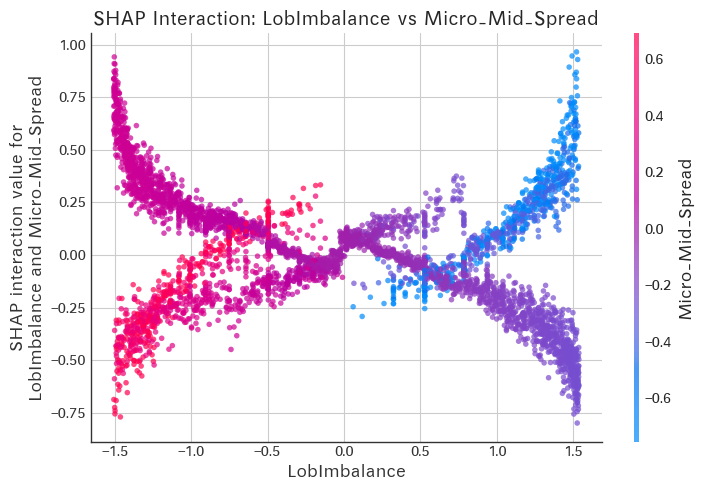

In [21]:
# 设定要分析的特征对
feat_x = 'LobImbalance'
feat_y = 'Micro_Mid_Spread'

# 数据清洗：剔除极端值以便绘图更好看 (保留中间 98%)
def filter_outliers(df, shap_values, f1, f2, percentile=1):
    mask = (df[f1] >= df[f1].quantile(percentile/100)) & \
           (df[f1] <= df[f1].quantile(1 - percentile/100)) & \
           (df[f2] >= df[f2].quantile(percentile/100)) & \
           (df[f2] <= df[f2].quantile(1 - percentile/100))
    return df[mask], shap_values[mask]

X_filtered, shap_filtered = filter_outliers(X_sample, shap_interaction_values, feat_x, feat_y)

plt.figure(figsize=(10, 6), dpi=150)
shap.dependence_plot(
    (feat_x, feat_y),
    shap_filtered, 
    X_filtered,
    display_features=X_filtered,
    show=False,
    alpha=0.7,
    dot_size=15
)

plt.title(f"SHAP Interaction: {feat_x} vs {feat_y}", fontsize=14)
plt.tight_layout()
plt.show()

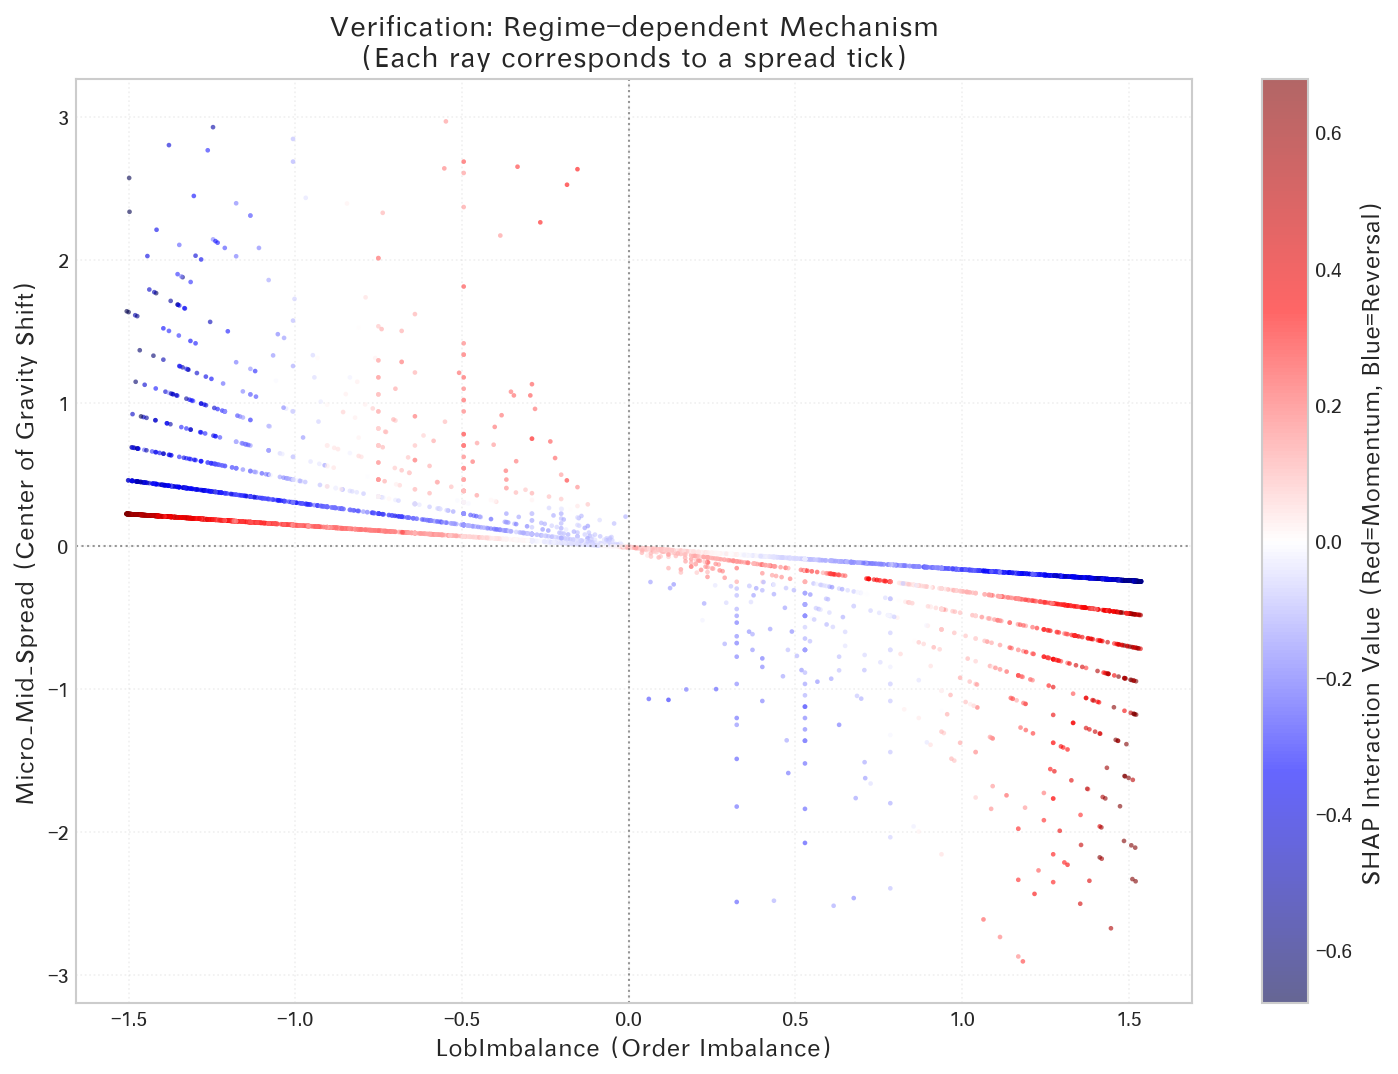

In [23]:
# 获取特征索引
idx_x = FEATURE_COLS.index(feat_x)
idx_y = FEATURE_COLS.index(feat_y)

# 提取交互值
interaction_effect_subset = shap_filtered[:, idx_x, idx_y] * 2

# 【视觉优化】计算动态颜色范围 (98%分位数)，增强对比度
c_max = np.percentile(np.abs(interaction_effect_subset), 98)

# 设置画布 DPI 提高清晰度
plt.figure(figsize=(12, 8), dpi=150)

# 绘制散点图
sc = plt.scatter(
    x=X_filtered[feat_x], 
    y=X_filtered[feat_y], 
    c=interaction_effect_subset, 
    cmap='seismic',     # 改用红蓝地震波色谱
    s=5,                # 缩小点的大小，避免重叠
    alpha=0.6,          # 调整透明度
    vmin=-c_max,        # 强制拉伸颜色下限
    vmax=c_max,         # 强制拉伸颜色上限
    edgecolor='none'
)

# 添加颜色条
cbar = plt.colorbar(sc)
cbar.set_label('SHAP Interaction Value (Red=Momentum, Blue=Reversal)', fontsize=12)

# 装饰
plt.xlabel(f'{feat_x} (Order Imbalance)', fontsize=12)
plt.ylabel(f'{feat_y} (Center of Gravity Shift)', fontsize=12)
plt.title('Verification: Regime-dependent Mechanism\n(Each ray corresponds to a spread tick)', fontsize=14)

# 优化辅助线风格 (黑色虚线)
plt.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.4)
plt.axvline(0, color='black', linestyle=':', linewidth=1, alpha=0.4)
plt.grid(True, linestyle=':', alpha=0.3)

plt.show()